In [15]:
import torch
from torch import nn
from torchvision import datasets
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [25]:
batch_size = 128
image_size = 64
color_channel = 3
gen_input = 100
gen_feature = 64
disc_feature = 64
epochs = 5
lr = 0.0002
beta1 = 0.5

In [5]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform

Compose(
    Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(64, 64))
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [6]:
from torch.utils.data import DataLoader
dataset = datasets.ImageFolder(root="data/celeba", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader

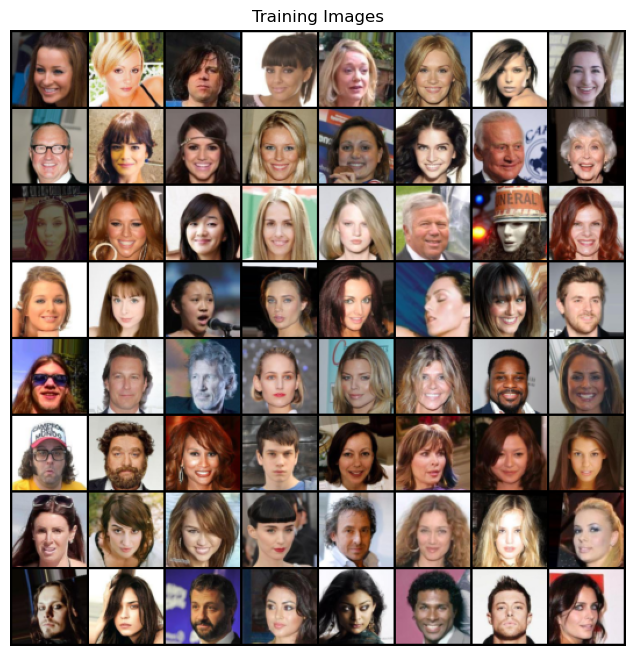

In [7]:
from torchvision.utils import make_grid
image = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis(False)
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(image[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=gen_input,
                out_channels=gen_feature * 8,
                kernel_size=4,
                stride=2,
                padding=0,
                bias=False,
            ),
            nn.BatchNorm2d(gen_feature * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=gen_feature * 8,
                out_channels=gen_feature * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(gen_feature * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=gen_feature * 4,
                out_channels=gen_feature * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(gen_feature * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=gen_feature * 2,
                out_channels=gen_feature,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(gen_feature),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=gen_feature,
                out_channels=color_channel,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x)

In [10]:
netG = Generator().to(device=device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [11]:
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(
                in_channels=color_channel,
                out_channels=disc_feature,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                in_channels=disc_feature,
                out_channels=disc_feature * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(disc_feature * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                in_channels=disc_feature * 2,
                out_channels=disc_feature * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(disc_feature * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                in_channels=disc_feature * 4,
                out_channels=disc_feature * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(disc_feature * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                in_channels=disc_feature * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.main(x)

In [12]:
netD = Discriminator().to(device=device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [27]:
loss_fn = nn.BCELoss()
fixed_noise = torch.randn(64, gen_input, 1, 1, device=device)
real_label, fake_label = 1, 0
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
fake_writer = SummaryWriter(f"logs/fake")
real_writer = SummaryWriter(f"logs/real")

In [28]:
step = 0
print("Starting Training Loop...")
for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        image = data[0].to(device)
        b_size = image.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        ouput = netD(image).view(-1)
        real_lossD = loss_fn(ouput, label)
        real_lossD.backward()
        noise = torch.randn(b_size, gen_input, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        ouput = netD(fake.detach()).view(-1)
        fake_lossD = loss_fn(ouput, label)
        fake_lossD.backward()
        lossD = real_lossD + fake_lossD
        optimizerD.step()
        netG.zero_grad()
        label.fill_(real_label)
        ouput = netD(fake).view(-1)
        lossG = loss_fn(ouput, label)
        lossG.backward()
        optimizerG.step()
        if i % 50 == 0:
            print(
                "[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f"
                % (epoch, epochs, i, len(dataloader), lossD.item(), lossG.item())
            )
            with torch.no_grad():
                fake = netG(fixed_noise)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(image[:64], normalize=True)
                fake_writer.add_image(
                    "CelebA Fake Images", img_grid_fake, global_step=step
                )
                real_writer.add_image(
                    "CelebA Real Images", img_grid_real, global_step=step
                )
                step += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: 0.4161	Loss_G: 1.1222
[0/5][50/1583]	Loss_D: 0.4686	Loss_G: 3.8352
[0/5][100/1583]	Loss_D: 0.8529	Loss_G: 6.6225
[0/5][150/1583]	Loss_D: 0.8186	Loss_G: 3.8865
[0/5][200/1583]	Loss_D: 0.8466	Loss_G: 6.5811
[0/5][250/1583]	Loss_D: 0.7000	Loss_G: 3.8670
[0/5][300/1583]	Loss_D: 0.7268	Loss_G: 4.7632
[0/5][350/1583]	Loss_D: 0.5688	Loss_G: 4.4971
[0/5][400/1583]	Loss_D: 0.9673	Loss_G: 7.7030
[0/5][450/1583]	Loss_D: 0.4901	Loss_G: 4.3517
[0/5][500/1583]	Loss_D: 0.7189	Loss_G: 5.3197
[0/5][550/1583]	Loss_D: 0.5806	Loss_G: 3.7887
[0/5][600/1583]	Loss_D: 1.3465	Loss_G: 3.2285
[0/5][650/1583]	Loss_D: 1.1666	Loss_G: 6.6246
[0/5][700/1583]	Loss_D: 0.6445	Loss_G: 4.3647
[0/5][750/1583]	Loss_D: 0.7095	Loss_G: 4.1795
[0/5][800/1583]	Loss_D: 0.5903	Loss_G: 4.7629
[0/5][850/1583]	Loss_D: 0.3803	Loss_G: 4.7156
[0/5][900/1583]	Loss_D: 0.7694	Loss_G: 4.7036
[0/5][950/1583]	Loss_D: 0.8351	Loss_G: 6.6493
[0/5][1000/1583]	Loss_D: 0.6899	Loss_G: 3.7017
[0/5][1050